In [1]:
# Pandas library for the pandas dataframes
import pandas as pd    
import numpy as np 

# Import Scikit-Learn library for the regression models
import sklearn         
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.feature_selection import f_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix

# Another statistic model library
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d

# Import plotting libraries
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt

# Set larger fontsize for all plots
matplotlib.rcParams.update({'font.size': 20})

# Command to automatically reload modules before executing cells
# not needed here but might be if you are writing your own library 
%load_ext autoreload
%autoreload 2
%matplotlib inline

from clean_split_data import clean_data
from clean_split_data import split_data

### Data

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data = clean_data(data)
X_train, X_test, y_train, y_test = split_data(data)

### Classifier Preprocessing

In [4]:
tree_count = [1, 10, 20, 30, 50, 75]
list_mse = []

In [5]:
for trees in tree_count:
    gradient_model = GradientBoostingClassifier(n_estimators=trees, learning_rate=0.1, max_depth=10, random_state=42)
    gradient_model.fit(X_train, (y_train))
    y_pred = gradient_model.predict(X_test)
    list_mse.append(mean_squared_error(y_test, y_pred))

Text(0.5, 1.0, 'MSE for different n_estimators')

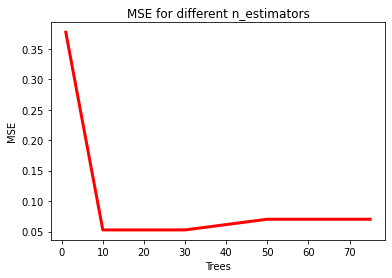

In [6]:
plt.plot(tree_count, list_mse, c='r', linewidth=3)
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.title('MSE for different n_estimators')

Therefore, n_estimators = 10 is the ideal choice.

### Classifier

In [7]:
tree_count = 10
gradient_model = GradientBoostingClassifier(n_estimators=tree_count, learning_rate=0.1,max_depth=10,random_state=42)
gradient_model.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=10, random_state=42)

### Gradient Boosting Prediction with all 10 parameters

In [8]:
def predict(test_data):
    
    #test_data = pd.DataFrame(test_data).T
    y_pred = np.round(gradient_model.predict(test_data))
   
    return y_pred

In [9]:
y_pred = predict(X_test)

In [10]:
'''Accuracy and MSE Using ALL 10 features'''

accuracy_1 = accuracy_score(y_test, y_pred)
print("Prediction accuracy MSE: ", mean_squared_error(y_test, y_pred))
print("Accuracy score", accuracy_score(y_test, y_pred))
#print('R-Squared Score',r2_score(y_test,y_pred))

Prediction accuracy MSE:  0.05263157894736842
Accuracy score 0.9473684210526315


### Backward Stepwise selection (MSE and AC Using 1 to 9 features)

In [11]:
'''Load the cleaned original dataset for below use'''
X = data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
y = data.diagnosis

'''A list of for the for-loop'''
n = [1,2,3,4,5,6,7,8,9]

list_MSE=[]
list_AC=[]
list_MSE_1=[]
list_AC_1=[]
selected_features = []

for i in n:
    '''Only passing the training data set into the Feature Selector'''
    '''Any preprocessing method should not be fitted on the whole dataset to prevent carrying information from the train set
       to test set'''
    sfs_backward = SequentialFeatureSelector(GradientBoostingClassifier(), 
                                             n_features_to_select=i,
                                             direction='backward').fit(X_train, y_train)
    selected = sfs_backward.get_support(indices=True)
    
    '''passing the selected features to the orginial dataset for each number of i'''
    f_names = np.array(X.columns)
    x_manip = X[f_names[selected]]
    selected_features.append(f_names[selected])
    #print("Selected input features using backward Stepwise Selection:\n", f_names[selected])

    X_train1, X_test1, y_train1, y_test1 = train_test_split(x_manip, y , test_size=0.2, random_state=42)

    model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1,max_depth=10,random_state=42)
    model.fit(X_train1,y_train1)
    
    y_pred1 = model.predict(X_test1)
    y_pred2 = model.predict(X_train1)
    
    list_AC.append(accuracy_score(y_test1, y_pred1))
    list_AC_1.append(accuracy_score(y_train1, y_pred2))
    list_MSE.append(mean_squared_error(y_test1, y_pred1))
    list_MSE_1.append(mean_squared_error(y_train1, y_pred2))

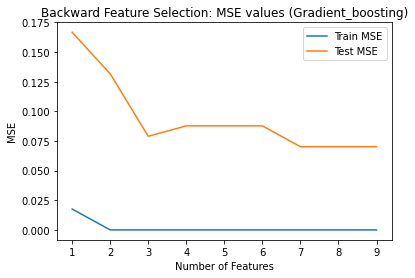

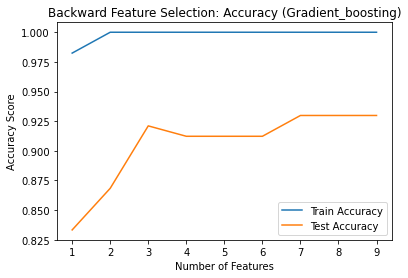

In [12]:
plt.plot(n, list_MSE_1, label = 'Train MSE')
plt.plot(n, list_MSE, label = "Test MSE")
plt.xlabel("Number of Features")
plt.ylabel("MSE")
plt.title("Backward Feature Selection: MSE values (Gradient_boosting)")
plt.legend()
plt.show()

plt.plot(n, list_AC_1, label = 'Train Accuracy')
plt.plot(n, list_AC, label = "Test Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Score")
plt.title("Backward Feature Selection: Accuracy (Gradient_boosting)")
plt.legend()
plt.show()

### Sample Train, Test, Split results

In [13]:
def sample_results():
    ''' 
    Returns the results and confusion matrix of the sample dataset from Breast Cancer Wisconsin Dataset.
    '''
    y_pred = gradient_model.predict(X_test)
    print("Prediction accuracy MSE: ", mean_squared_error(y_test, y_pred))
    print("Mean accuracy on test set", gradient_model.score(X_test, y_test))
    print("The confusion matrix for the sample dataset using a decision tree is displayed below: ")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(gradient_model, X_test, y_test)
    plt.show()
    
    return

Prediction accuracy MSE:  0.05263157894736842
Mean accuracy on test set 0.9473684210526315
The confusion matrix for the sample dataset using a decision tree is displayed below: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



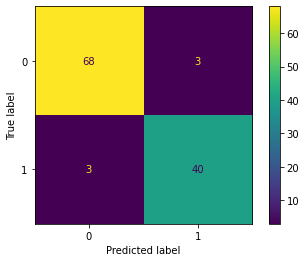

In [14]:
'''This matrix is only for Non-stepwise SVM only'''
sample_results()

Prediction accuracy MSE:  0.07017543859649122
Mean accuracy on test set 0.9298245614035088
The confusion matrix for the sample dataset using a decision tree is displayed below: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        71
           1       0.91      0.91      0.91        43

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



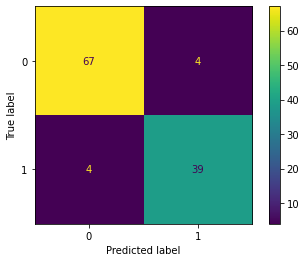

In [15]:
'''This matrix is for Backward Stepwise SVM with 9 features'''
plot_confusion_matrix(model, X_test1, y_test1)
print("Prediction accuracy MSE: ", mean_squared_error(y_test1, y_pred1))
print("Mean accuracy on test set", model.score(X_test1, y_test1))
print("The confusion matrix for the sample dataset using a decision tree is displayed below: ")
print(classification_report(y_test1, y_pred1))

plt.show()

In [16]:
print(list_AC)
print(list_MSE)

[0.8333333333333334, 0.868421052631579, 0.9210526315789473, 0.9122807017543859, 0.9122807017543859, 0.9122807017543859, 0.9298245614035088, 0.9298245614035088, 0.9298245614035088]
[0.16666666666666666, 0.13157894736842105, 0.07894736842105263, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.07017543859649122, 0.07017543859649122, 0.07017543859649122]


**Based on the above information, Best number of parameters for gradient_boosting is 7** 

###  Optimized Gradient Boosting Predictor ###

In [21]:
selected_features[6]

array(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean'],
      dtype=object)

In [22]:
def feature_names():
    '''
    Returns array of input features of best performing backwards stepwise selection test.
    '''
    
    return ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
             'concavity_mean', 'concave points_mean', 'symmetry_mean']

In [23]:
def predict(test_data):
    '''
    Takes test data and uses classifier to predict boolean output.
    '''
    X = data[feature_names()]
    y = data.diagnosis
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    gradient_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1,max_depth=10, random_state=42)
    gradient_model.fit(X_train,(y_train))
    y_pred = gradient_model.predict(test_data)
    
    return y_pred